The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than imagenet, trainable on a single GPU.

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from skimage import io
from skimage.io import imread
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import PReLU
from keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping

# Supress warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.__version__

'2.6.4'

In [3]:
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)
train = '../input/histopathologic-cancer-detection/train'
test = '../input/histopathologic-cancer-detection/test'

In [4]:
display(train_labels.info(),train_labels.head(),train_labels.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


None

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


,id,label
count,220025,220025
unique,220025,2
top,f38a6374c348f90b587e046aac6079959adf3835,0
freq,1,130908


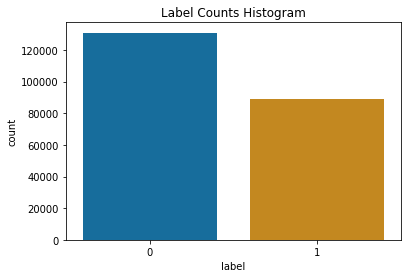

In [5]:
sns.countplot(x=train_labels['label'], palette='colorblind').set(title='Label Counts Histogram');

We can see that the the data is a little unbalanced, so before moving forward, we have to balance the label counts in dataset:

In [6]:
train_labels['label'] = train_labels['label'].astype(float)

In [7]:
train_labels_pos = train_labels[train_labels['label']==1]
train_labels_neg = train_labels[train_labels['label']==0]

In [8]:
train_labels_neg = train_labels_neg.sample(n = train_labels_pos.shape[0])

In [9]:
print(train_labels_neg.shape[0])
print(train_labels_pos.shape[0])

89117
89117


In [10]:
train_labels_balanced = pd.concat([train_labels_neg,train_labels_pos]).sample(frac=1, random_state=12345).reset_index(drop=True)
train_labels_balanced.head()

,id,label
0,f33840b3f1bab142a6429e8755b0ad6ed052e998,0.0
1,eae0400f8d0b0e50d6b6a3d0109161d4350bfdbe,1.0
2,5117a86be1ab45d86e29bd4166eec7fdca3cf425,1.0
3,12e65c1e7ad4b0aff1a716ab5da24bb5e149bea4,1.0
4,4d3ece66920d89a8225ed93dccc7f333d0f18303,0.0


Now that the data is balanced, we can go ahead and view some of the images from the train dataset:

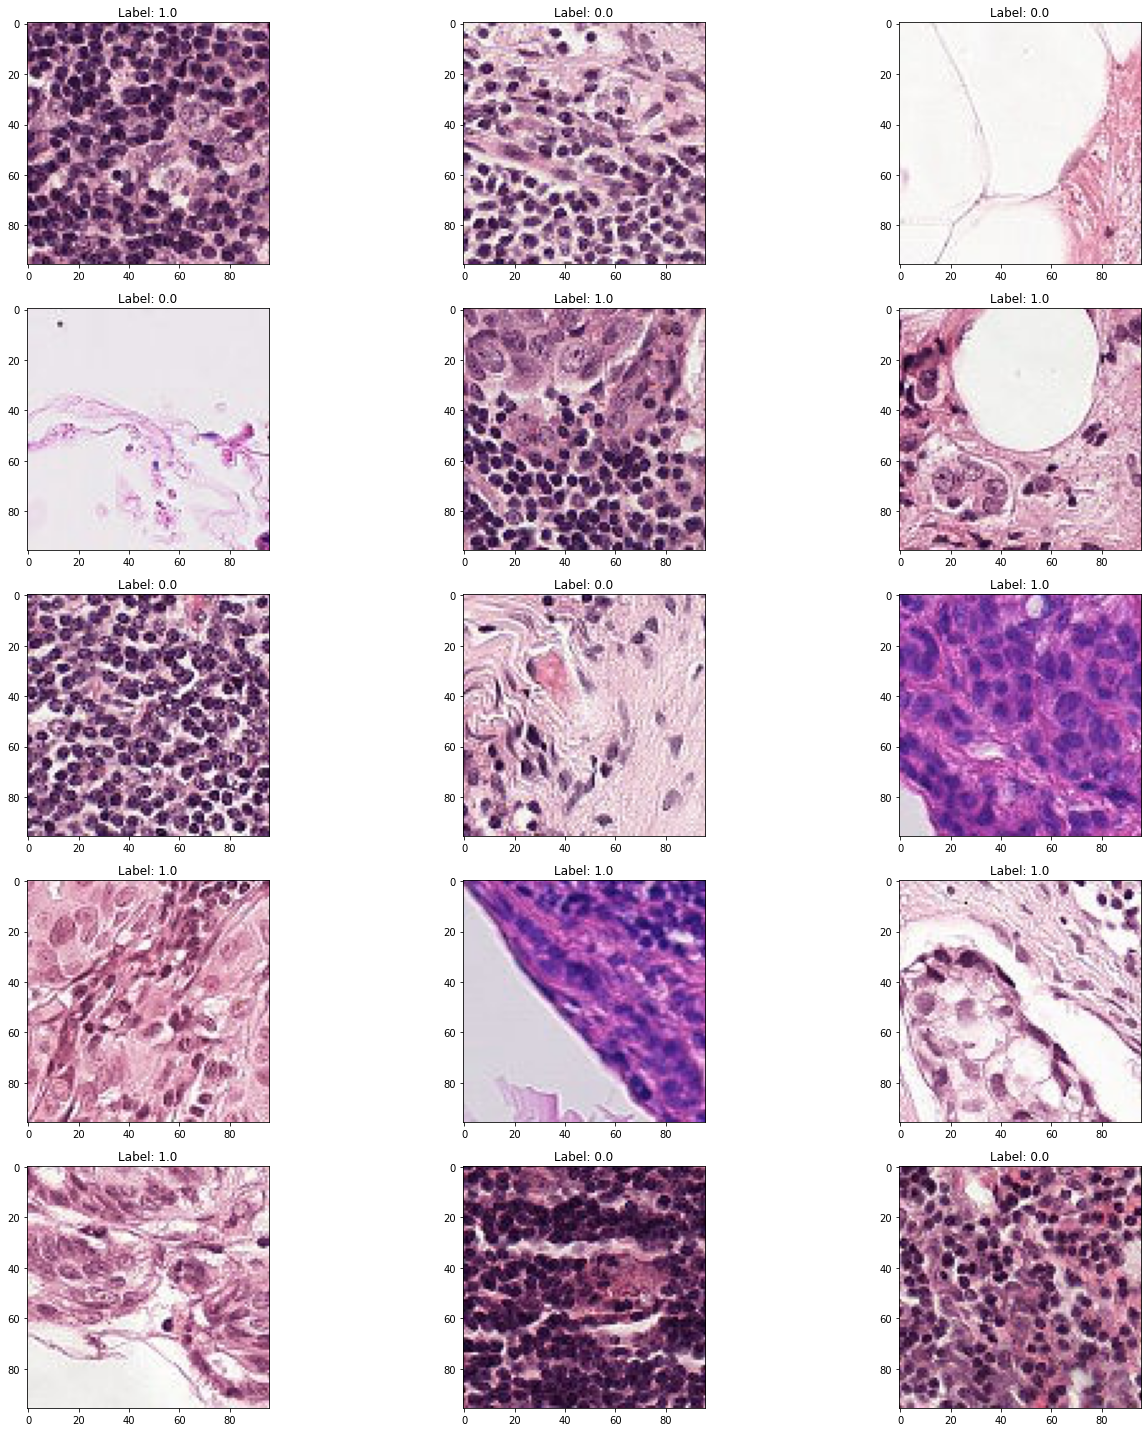

In [11]:
img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_labels_balanced.iloc[47,0]}.tif')

sample_imgs = np.random.choice(train_labels_balanced.index,15)

fig, ax = plt.subplots(5, 3,figsize=(20,20))

for i in range(0, sample_imgs.shape[0]):
    ax = plt.subplot(5, 3, i+1)
    img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{train_labels_balanced.iloc[sample_imgs[i],0]}.tif')
    ax.imshow(img)
    lab = train_labels_balanced.iloc[sample_imgs[i],1]
    ax.set_title('Label: %s'%lab)
    
plt.tight_layout()

We can clearly see the images, but without the labels, its hard for a non-medical professional to tell which images are cancerous or not. 

#### Split the train_labels dataset into training/validation sets:

In [12]:
train_df, valid_df = train_test_split(train_labels, test_size=0.25, random_state=42, stratify=train_labels.label)

In [13]:
train_df['id'] = train_df['id'] + '.tif'
valid_df['id'] = valid_df['id'] + '.tif'

Before constructing the model, we need to conduct data-preprocessing, and this will be done through an ImageDataGenerator. I followed the tutorial from the link below in order to help with the code:

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Before running the train_datagen image generator, the label values need to be converted to string, otherwise the image generator will read an error:

In [14]:
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [15]:
train_datagen=ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_dataframe(dataframe=train_df,directory=train,
                x_col="id",y_col="label",batch_size=64,seed=42,shuffle=True,
                class_mode="binary",target_size=(96,96))

valid_generator=train_datagen.flow_from_dataframe(dataframe=valid_df,directory=train,
                x_col="id",y_col="label",batch_size=64,seed=42,shuffle=True,
                class_mode="binary",target_size=(96,96))

Found 165018 validated image filenames belonging to 2 classes.
Found 55007 validated image filenames belonging to 2 classes.


I then went ahead and constructed a Convolutional Neural Network Model(CNN). 

In [16]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(96,96,3),activation='relu',strides=(2,2)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',strides=(2,2)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics='accuracy')


2022-10-11 06:40:59.133770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 06:40:59.137328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 06:40:59.137998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 06:40:59.138872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 47, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

Next we need to fit the model. I used the following article as a tutorial to fit the model:

https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c



In [18]:
early = EarlyStopping(monitor='val_loss',patience=2)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20, callbacks = early, verbose=1)

2022-10-11 06:41:03.018392: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-10-11 06:41:04.864451: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2578/2578 [==============================] - 1583s 611ms/step - loss: 0.3833 - accuracy: 0.8339 - val_loss: 0.3683 - val_accuracy: 0.8427
Epoch 2/20
2578/2578 [==============================] - 398s 154ms/step - loss: 0.3180 - accuracy: 0.8654 - val_loss: 0.4065 - val_accuracy: 0.8250
Epoch 3/20
2578/2578 [==============================] - 282s 110ms/step - loss: 0.2782 - accuracy: 0.8843 - val_loss: 0.3996 - val_accuracy: 0.8397


As a result of early stopping, it appears that the ideal amount of epochs would be 4- so I am going to run the same model again, but change the number of epochs from 20 to 4. 

In [19]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=4, callbacks = early, verbose=1)

Epoch 1/4
2578/2578 [==============================] - 283s 110ms/step - loss: 0.2462 - accuracy: 0.8996 - val_loss: 0.3706 - val_accuracy: 0.8537
Epoch 2/4
2578/2578 [==============================] - 296s 115ms/step - loss: 0.2198 - accuracy: 0.9116 - val_loss: 0.3875 - val_accuracy: 0.8484
Epoch 3/4
2578/2578 [==============================] - 287s 111ms/step - loss: 0.1923 - accuracy: 0.9227 - val_loss: 0.3031 - val_accuracy: 0.8765
Epoch 4/4
2578/2578 [==============================] - 296s 115ms/step - loss: 0.1645 - accuracy: 0.9361 - val_loss: 0.9008 - val_accuracy: 0.7371


In [20]:
test_set = os.listdir('../input/histopathologic-cancer-detection/test/')
test_df = pd.DataFrame(test_set)
test_df.columns = ['id']
test_df.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [21]:
test_datagen=ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory="../input/histopathologic-cancer-detection/test/",
                x_col="id",batch_size=64,seed=1234,shuffle=False,
                class_mode=None,target_size=(96,96))

Found 57458 validated image filenames.


In [22]:
STEP_SIZE_TEST=test_generator.n/2

pred = model.predict_generator(generator=test_generator,steps=STEP_SIZE_TEST, verbose = 1)

28729/28729 [==============================] - 409s 14ms/step


In [23]:
predictions = []

for p in pred:
    if p >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

In [24]:
submission = test_df.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=predictions
submission.to_csv('submission.csv',index=False)

This model ended up scoring a 0.7943 on Kaggle. I wanted to see I I could improve the accuracy score in any way, so I made a new model using the same baseline model as before, but added an extra convolutional layer:

In [25]:
model_2 = Sequential()
model_2.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(96,96,3),activation='relu',strides=(2,2)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',strides=(2,2)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2,2)))
#Extra layer:
model_2.add(Conv2D(filters=128,kernel_size=(3,3),input_shape=(96,96,3),activation='relu',strides=(2,2)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Flatten())
model_2.add(Dense(512,activation='relu'))
model_2.add(Dense(1,activation='sigmoid'))
model_2.compile(optimizer='Adam',loss='binary_crossentropy',metrics='accuracy')


In [26]:
STEP_SIZE_TEST=test_generator.n/2

pred_2 = model_2.predict_generator(generator=test_generator,steps=STEP_SIZE_TEST, verbose = 1)

28729/28729 [==============================] - 73s 3ms/step


In [27]:
predictions_2 = []

for p_2 in pred_2:
    if p_2 >= 0.5:
        predictions_2.append(1)
    else:
        predictions_2.append(0)

In [28]:
submission_2 = test_df.copy()
submission_2['id']=submission_2['id'].str[:-4]
submission_2['label']=predictions_2
submission_2.to_csv('submission_2.csv',index=False)

When I ran this model, it only scored a 0.7611. I had expected this model to perform better than the 1st one given the extra layer I had added, so I was definitely surprised. Comparing that to the original model's score of 0.7943, the 1st model was clearly the best performing model. If I want to improve on this model, I could always add extra layers, or change the number of epochs.

Citations:

1)https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

2) https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c